<h1>MODEL TRAINER</h1>

In [1]:
#LOAD DEPENDENCIES
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import applications
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Model, Input
from sklearn.utils import class_weight
import efficientnet.keras as efn 
from efficientnet.keras import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras import Model, layers

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [2]:
#LOAD THE DATA
train_data_dir = "dataset_both/train/"
validation_data_dir = "dataset_both/validation/"
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)
print("Data folders found!")
print("The Input size is set to ", model_input) 

Data folders found!
The Input size is set to  Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)


In [3]:
#DATA GENERATORS

batch_size = 16

train_datagen = ImageDataGenerator(preprocessing_function=efn.preprocess_input)
         
val_datagen = ImageDataGenerator(preprocessing_function=efn.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        classes=['0_Normal_XRAY', 
                 '1_Covid19_XRAY', 
                 '2_Pneumonia_XRAY', 
                 '3_Normal_CT', 
                 '4_Covid19_CT', 
                 '5_Pneumonia_CT'])

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=['0_Normal_XRAY', 
                 '1_Covid19_XRAY', 
                 '2_Pneumonia_XRAY', 
                 '3_Normal_CT', 
                 '4_Covid19_CT', 
                 '5_Pneumonia_CT'])

#CHECK  THE NUMBER OF SAMPLES
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print("Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

num_classes= len(train_generator.class_indices)

print('Model set to train', num_classes, 'classes')

if nb_train_samples and nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 21052 images belonging to 6 classes.
Found 5260 images belonging to 6 classes.
Train samples found!
Validation samples found!
Model set to train 6 classes
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [4]:
#Weight each class

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1.34123344 3.42308943 0.94167114 0.63620429 0.5775583  1.67478123]


In [5]:
# EfficientNetB0 

#TRANSFER LEARNING
def EfficientNetB0_builder(model_input):
    EfficientNetB0_builder = efn.EfficientNetB0(weights='imagenet', include_top=False, input_tensor=model_input)
    
#FINE TUNING
    for layer in EfficientNetB0_builder.layers:
        layer.trainable = False
    for BatchNormalization in EfficientNetB0_builder.layers:
        BatchNormalization.trainable = True
    x = EfficientNetB0_builder.layers[-1].output #-189 is the best
    x = GlobalAveragePooling2D(name='GAP-efficientnetb0')(x)
    x = Dropout(0.5, name='Dropout-efficientnetb0')(x)
    predictions = Dense(num_classes, activation='softmax', name='Softmax-efficientnetb0')(x)
    model = Model(inputs=EfficientNetB0_builder.input, outputs=predictions, name='efficientnetb0')
    return model

#INITIALIZE THE MODEL
efficientnetb0_model = EfficientNetB0_builder(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
efficientnetb0_model.summary()
print("Model successfully built!")

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_________________________________________

In [6]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 16

epochs = 25

start_time = time.time()

optimizer = Adam(lr=0.0001)

efficientnetb0_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.000001)

callbacks = [reduce_lr]

# MODEL TRAINING

history = efficientnetb0_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  callbacks=callbacks, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
print()

#SAVE AFTER TRAINING COMPLETES

efficientnetb0_model.save('weights/Both_baselines/Both-Baseline_EfficientNetB0.h5')

#SAVE THE HISTORY FOR EVALUATION

from pickle import dump
dump(history, open('history/Both_baselines/Both-Baseline_EfficientNetB0.pkl', 'wb'))

print()
print()
print("The Model weights and history are successfully trained and saved!")

Epoch 1/25
1315/1315 [==============================] - 304s 231ms/step - loss: 0.3053 - acc: 0.8947 - val_loss: 0.1176 - val_acc: 0.9615
Epoch 2/25
1315/1315 [==============================] - 289s 220ms/step - loss: 0.1075 - acc: 0.9649 - val_loss: 0.0974 - val_acc: 0.9664
Epoch 3/25
1315/1315 [==============================] - 289s 220ms/step - loss: 0.0664 - acc: 0.9776 - val_loss: 0.0685 - val_acc: 0.9785
Epoch 4/25
1315/1315 [==============================] - 290s 220ms/step - loss: 0.0471 - acc: 0.9835 - val_loss: 0.0735 - val_acc: 0.9743
Epoch 5/25
1315/1315 [==============================] - 289s 220ms/step - loss: 0.0317 - acc: 0.9892 - val_loss: 0.0994 - val_acc: 0.9737

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/25
1315/1315 [==============================] - 288s 219ms/step - loss: 0.0198 - acc: 0.9940 - val_loss: 0.0573 - val_acc: 0.9846
Epoch 7/25
1315/1315 [==============================] - 288s 219ms/step - loss: 0.0109 - ac

In [5]:
import itertools
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras import applications
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import matplotlib.patheffects as path_effects
%matplotlib inline

In [6]:
from keras.models import load_model

efficientnetb0_model = load_model('weights/Both_baselines/Both-Baseline_EfficientNetB0.h5')
print("The EfficientNet Baseline Model is Loaded")

The EfficientNet Baseline Model is Loaded


In [7]:
#EfficientNetB0 Model Results

#evaluate accuracy
efficientnetb0_model_y_pred = efficientnetb0_model.predict_generator(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)

efficientnetb0_model_accuracy = accuracy_score(Y_test, efficientnetb0_model_y_pred.argmax(axis=-1))
print('The accuracy of the EfficientNetB0 model is: ', efficientnetb0_model_accuracy)

#evaluate mean squared error
efficientnetb0_model_mse = mean_squared_error(Y_test, efficientnetb0_model_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the EfficientNetB0 model is: ', efficientnetb0_model_mse)

#evaluate mean squared log error
efficientnetb0_model_msle = mean_squared_log_error(Y_test, efficientnetb0_model_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the EfficientNetB0 model is: ', efficientnetb0_model_msle)

The accuracy of the EfficientNetB0 model is:  0.9872623574144487
The Mean Squared Error of the EfficientNetB0 model is:  0.037262357414448666
The Mean Squared Log Error of the EfficientNetB0 model is:  0.01036129794685383


              precision    recall  f1-score   support

           0     0.9551    0.9755    0.9652       654
           1     1.0000    0.9844    0.9921       256
           2     0.9815    0.9710    0.9762       931
           3     0.9892    0.9964    0.9928      1378
           4     0.9967    0.9901    0.9934      1518
           5     1.0000    1.0000    1.0000       523

    accuracy                         0.9873      5260
   macro avg     0.9871    0.9862    0.9866      5260
weighted avg     0.9874    0.9873    0.9873      5260

Normalized confusion matrix
[[0.9755 0.     0.0245 0.     0.     0.    ]
 [0.0117 0.9844 0.0039 0.     0.     0.    ]
 [0.029  0.     0.971  0.     0.     0.    ]
 [0.     0.     0.     0.9964 0.0036 0.    ]
 [0.     0.     0.     0.0099 0.9901 0.    ]
 [0.     0.     0.     0.     0.     1.    ]]


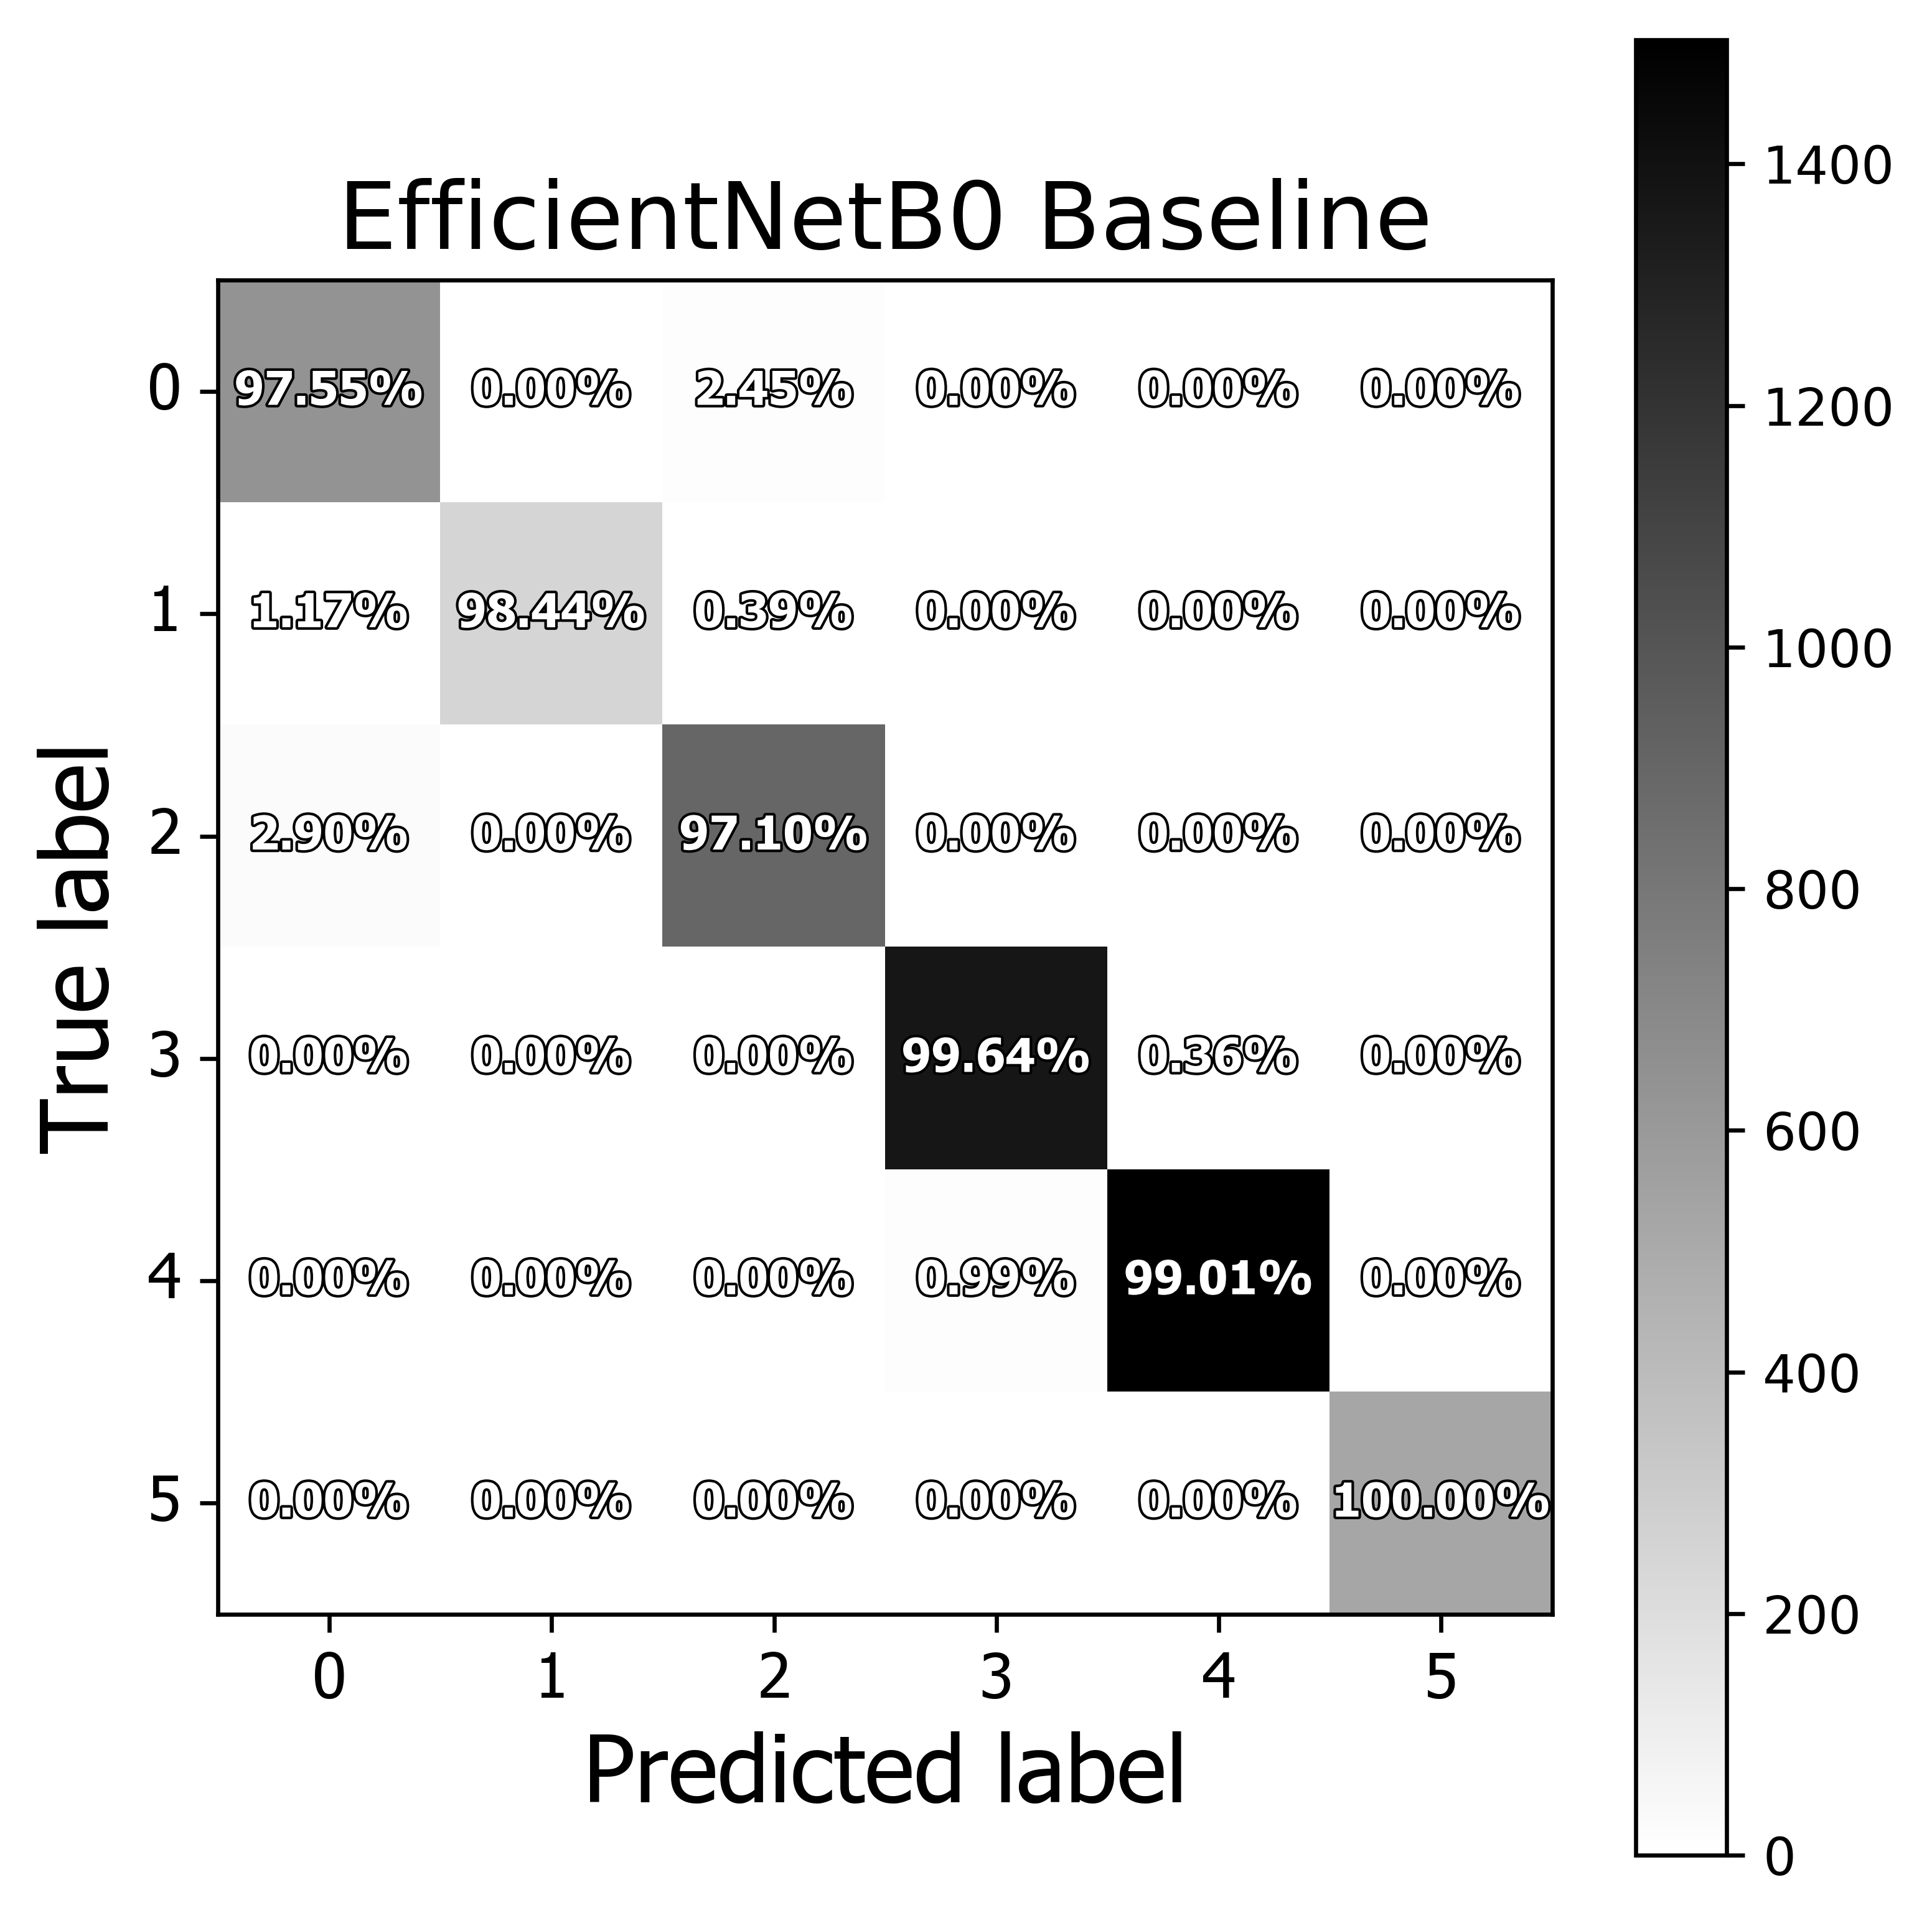

In [8]:
# EfficientNet Confusion Matrix (Normalized)

fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title='EfficientNetB0 Baseline',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")
#     plt.rcParams.update({'font.size': 70})

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3', '4', '5']
print(classification_report(Y_test,efficientnetb0_model_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,efficientnetb0_model_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=600)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.savefig("figures/Both_baselines/EfficientNetB0/confusion_matrix_normalized-efficientnetb0.jpg", bbox="tight", dpi=300)
plt.show()

              precision    recall  f1-score   support

           0     0.9551    0.9755    0.9652       654
           1     1.0000    0.9844    0.9921       256
           2     0.9815    0.9710    0.9762       931
           3     0.9892    0.9964    0.9928      1378
           4     0.9967    0.9901    0.9934      1518
           5     1.0000    1.0000    1.0000       523

    accuracy                         0.9873      5260
   macro avg     0.9871    0.9862    0.9866      5260
weighted avg     0.9874    0.9873    0.9873      5260

Confusion matrix, without normalization
[[ 638    0   16    0    0    0]
 [   3  252    1    0    0    0]
 [  27    0  904    0    0    0]
 [   0    0    0 1373    5    0]
 [   0    0    0   15 1503    0]
 [   0    0    0    0    0  523]]


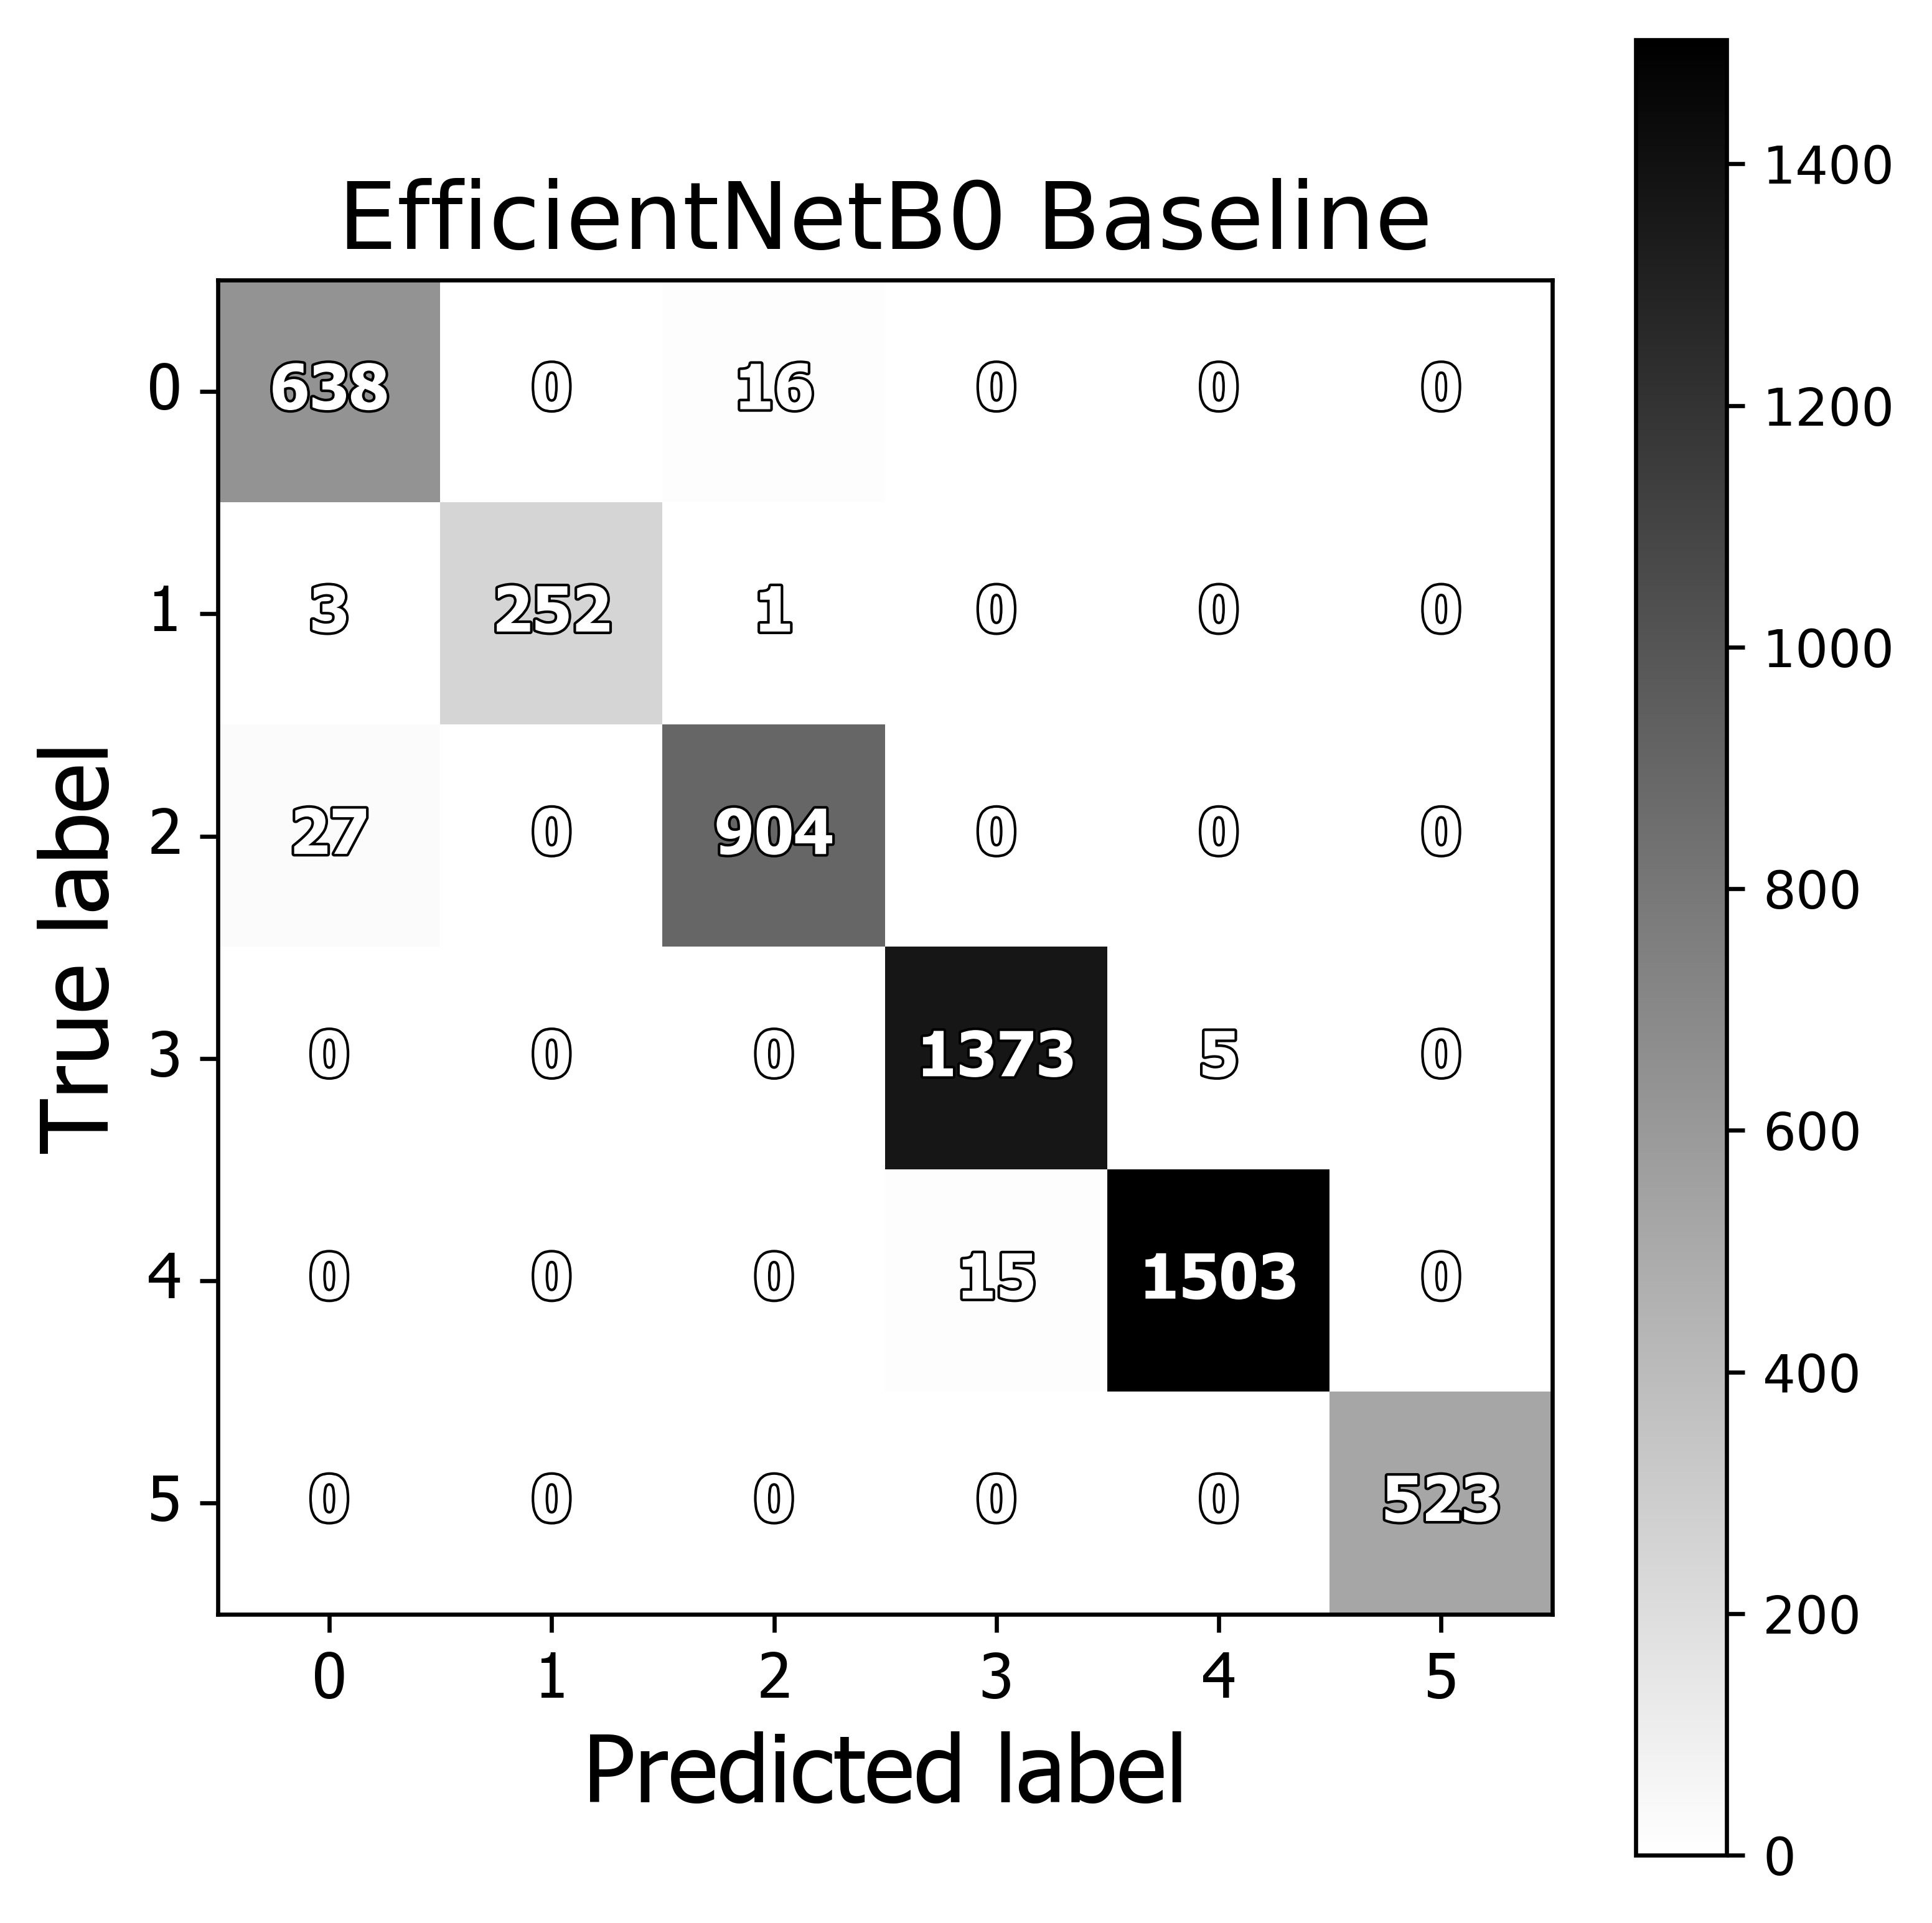

In [9]:
# EfficientNet Confusion Matrix

fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='EfficientNetB0 Baseline',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")
#     plt.rcParams.update({'font.size': 70})

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, cm[i, j],
                 fontfamily = 'Tahoma', 
                 fontsize=12, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3', '4', '5']
print(classification_report(Y_test,efficientnetb0_model_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,efficientnetb0_model_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=600)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.savefig("figures/Both_baselines/EfficientNetB0/confusion_matrix-efficientnetb0.jpg", bbox="tight", dpi=300)
plt.show()

In [12]:
#CURVES

import scikitplot 

plt.rcParams.update({'figure.figsize': [6,6]})
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.borderpad': 0.2})
plt.rcParams.update({'legend.fontsize': 'xx-large'})
plt.rcParams.update({'legend.frameon': True})

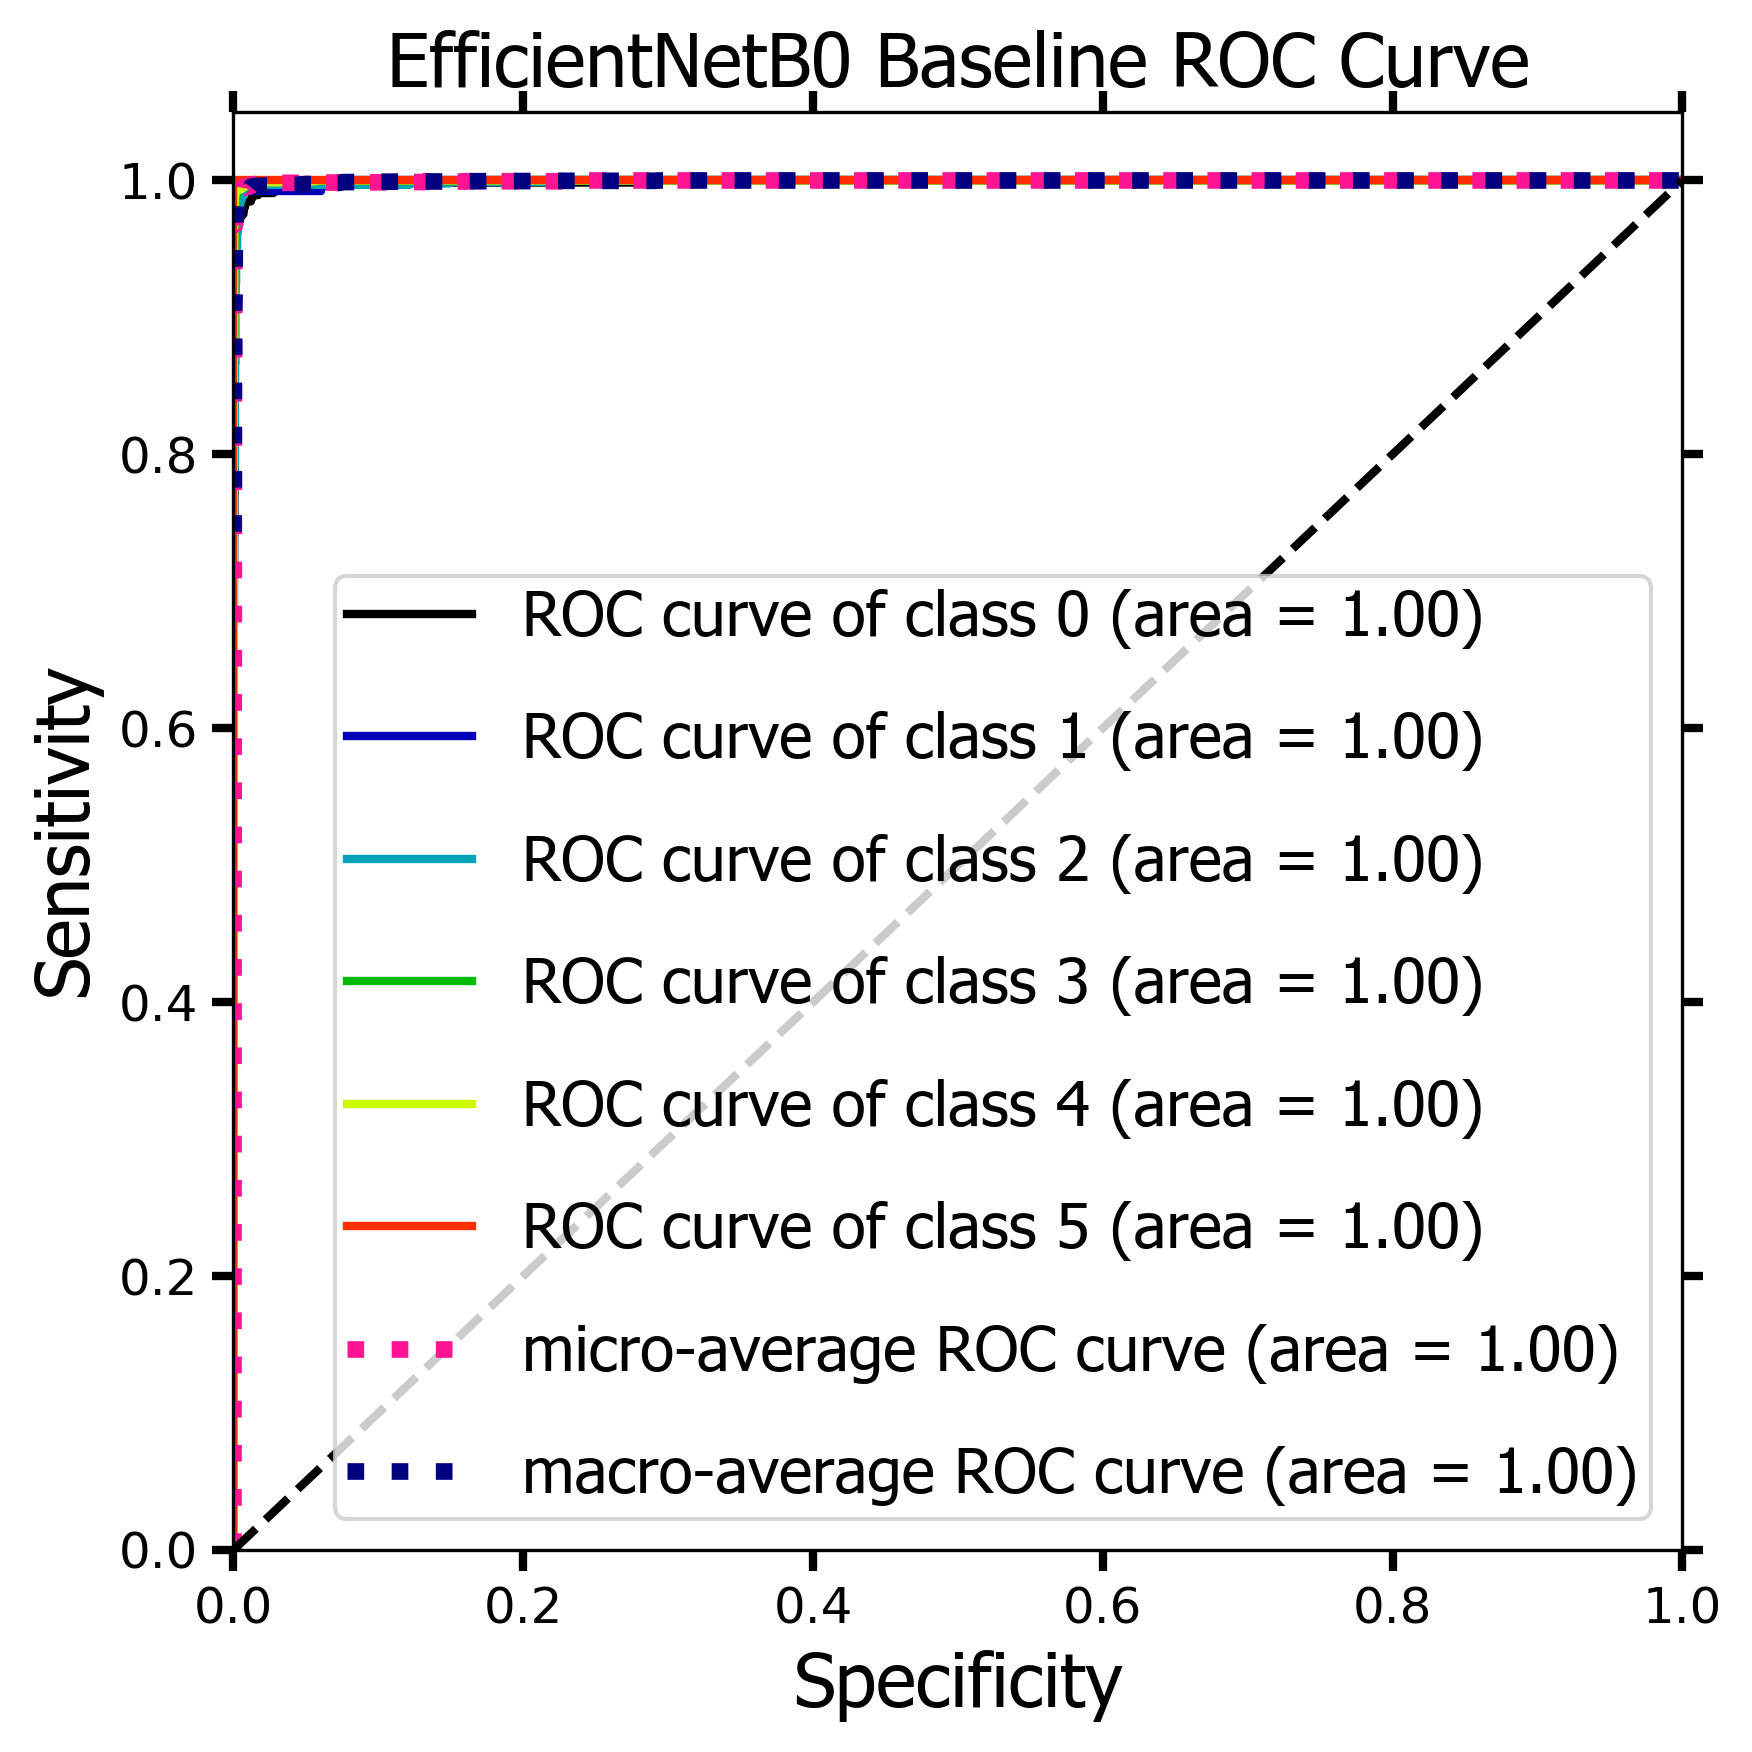

In [13]:
y_probas = efficientnetb0_model.predict(validation_generator)
scikitplot.metrics.plot_roc(Y_test, y_probas)
plt.title('EfficientNetB0 Baseline ROC Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Specificity', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Sensitivity', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
legend = plt.legend(loc="lower right", fontsize=15, labelspacing=1)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.savefig("figures/Both_baselines/EfficientNetB0/ROC_Curve-efficientnetb0.jpg", dpi=600)
plt.show()

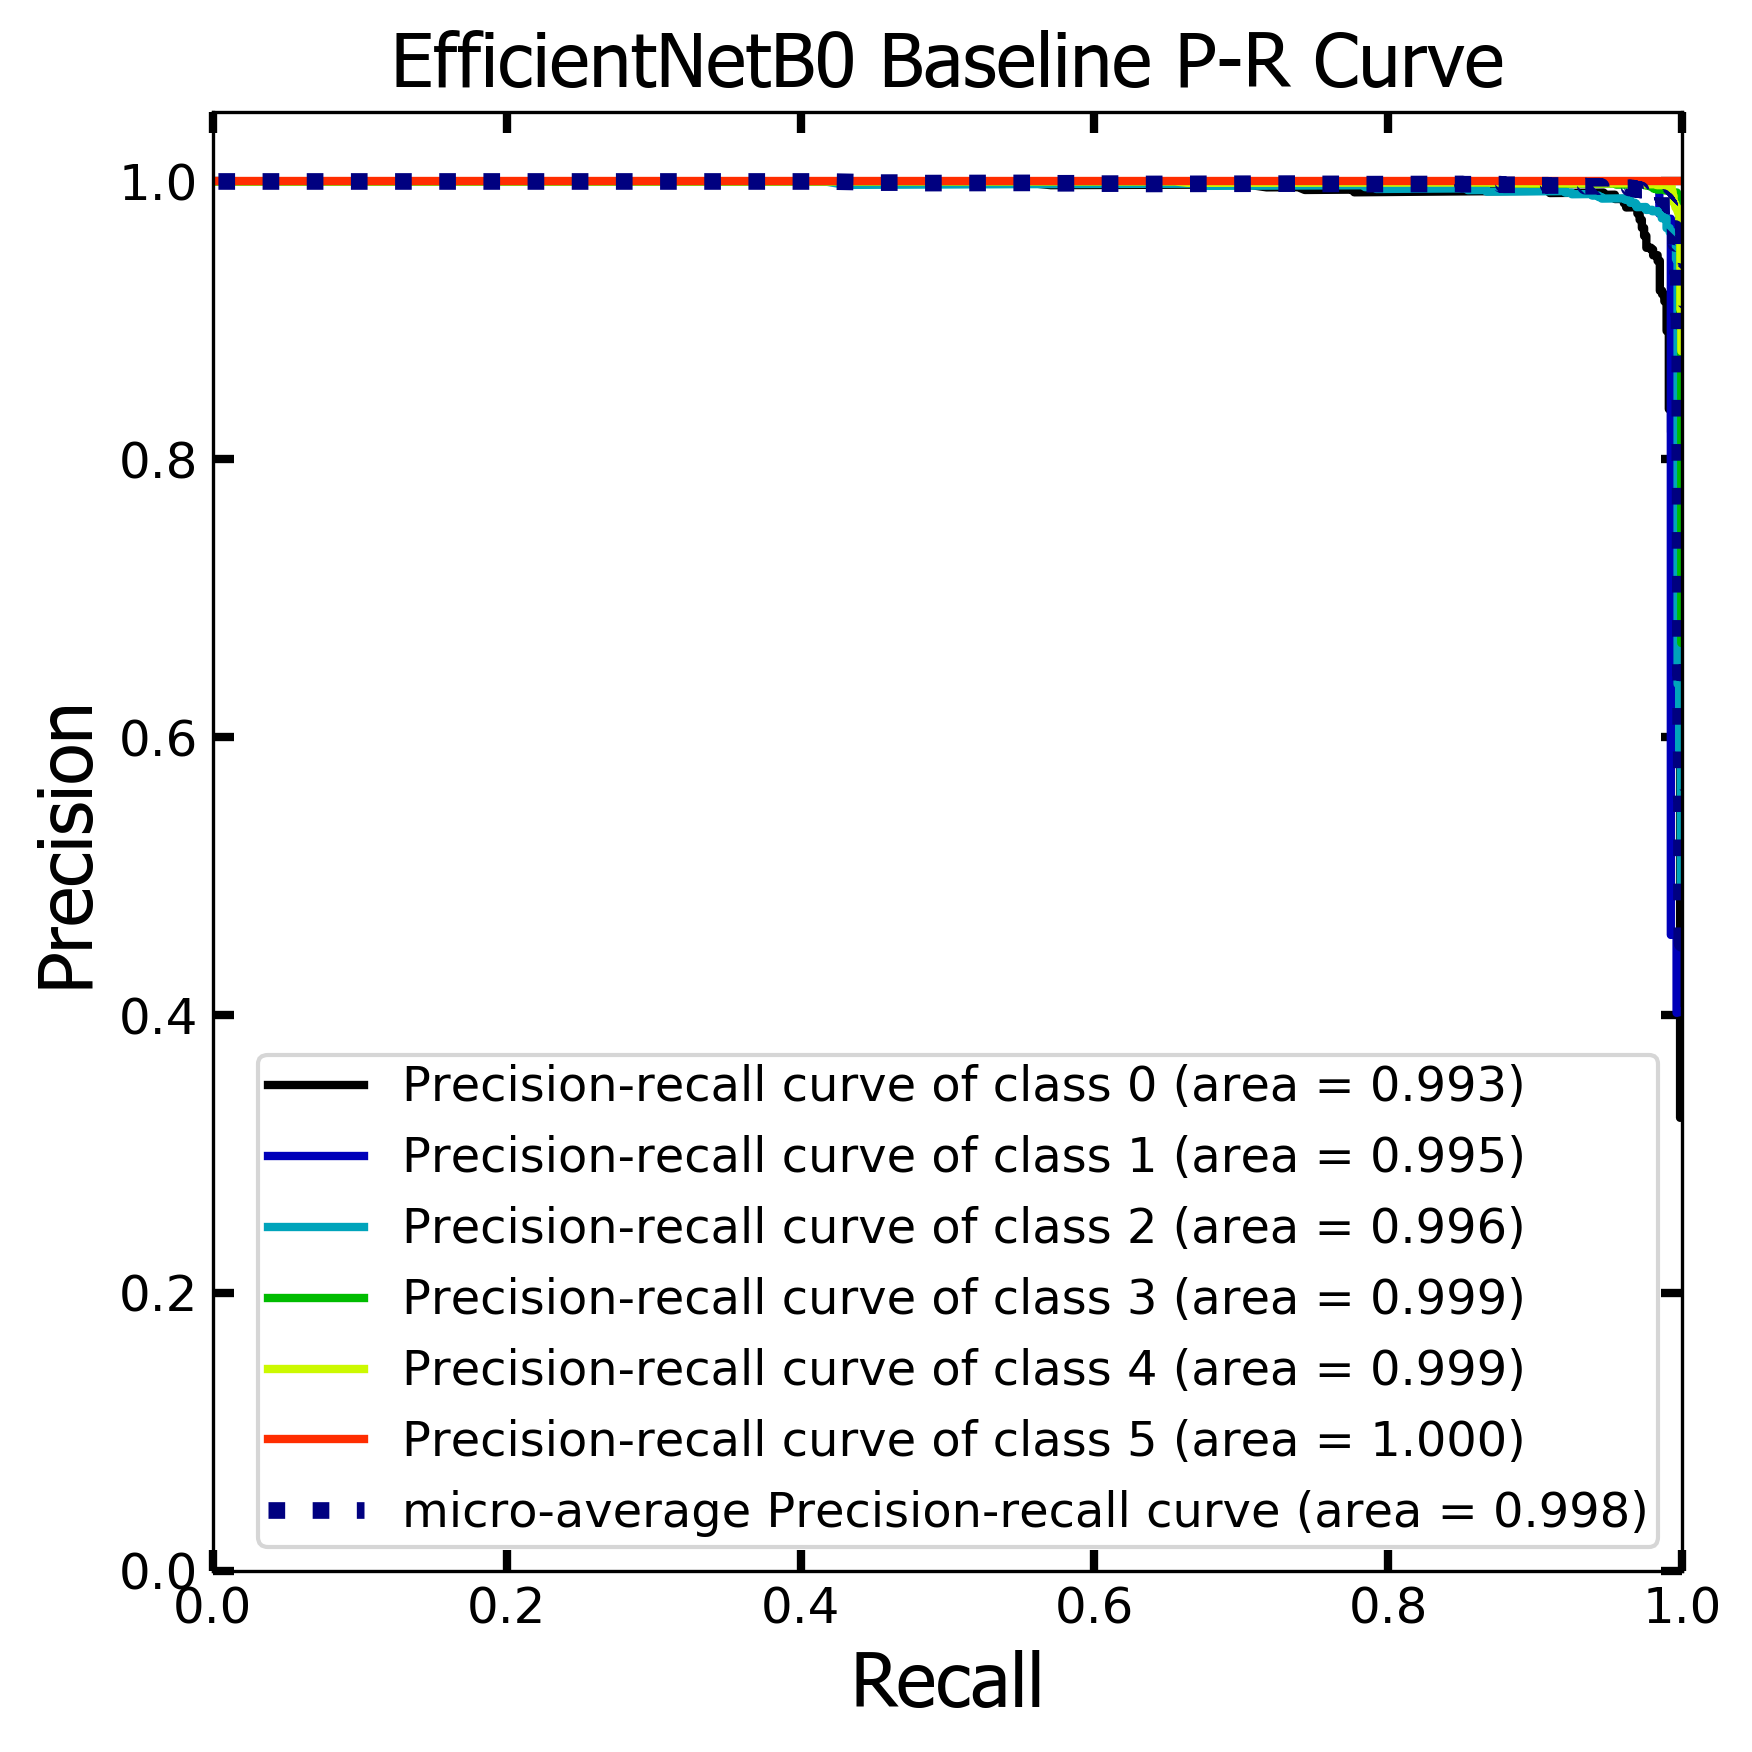

In [14]:
y_probas = efficientnetb0_model.predict(validation_generator)
scikitplot.metrics.plot_precision_recall(Y_test, y_probas)
plt.title('EfficientNetB0 Baseline P-R Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Recall', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Precision', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
plt.legend(loc="lower right", fontsize=11.5, labelspacing=0.5)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.savefig("figures/Both_baselines/EfficientNetB0/PR_Curve-efficientnetb0.jpg", dpi=600)
plt.show()